# (5) Inject missingness into the (time-series) dataset
Insert missingness into a dataset and save the corresponding ground truth m_graph and missingness model parameters. 
We use an AFAAgent that is based on a propensity score model to model the desired missingness and sample from it. 

__Note__: Only suitable for fully observed datasets where we want to test what happens under missingness. If your dataset already has missingness, please run `preparation03_missingness_assumptions` instead to define what you know about the missing data process. 

In [1]:
%load_ext autoreload
%autoreload 2

### Define paths 

In [2]:
from afa.configurations.utils_ts import specify_default_paths_ts
# which dataset to work on 
dataset_name   = "synthetic_2"

# name for of missingness scenario 
miss_scenario  = 'MCAR_1'

# original data paths
paths_gt = specify_default_paths_ts(dataset_name = dataset_name , 
                                    miss_scenario = None) 

# new missing data paths
paths_miss = specify_default_paths_ts(dataset_name = dataset_name , 
                                      miss_scenario = miss_scenario) 

# save miss model files also in ground truth folder
m_graph_adj_gt_file     = paths_miss['data_dir']  + 'm_graphs/'  + 'ground_truth/' + 'm_graph_adjacencies.csv'
ps_model_weights_gt_file   = paths_miss['data_dir']  + 'm_graphs/'  + 'ground_truth/' + 'weights.csv'

## Load dataset without missingness 
At first, we want to load the dataset

Includes loading: 
- superfeature mapping
- problem
- afa_problem 

In [3]:
from afa.data_modelling.datasets.data_loader.data_loader_ts import DataLoader_ts

2023-03-31 14:02:15.035664: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-31 14:02:15.133286: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-31 14:02:15.133298: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-31 14:02:25.501109: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [4]:
data_loader = DataLoader_ts(    data_file                  = paths_gt['data_file'],
                                temporal_data_file         = paths_gt['temporal_data_file'],
                                 superfeature_mapping_file = paths_gt['superfeature_mapping_file'],
                                 problem_file              = paths_gt['problem_file'],
                                 afa_problem_files         = paths_gt['afa_problem_files'],
                                 folds_file                = paths_gt['folds_file'])

dataset = data_loader.load() 

Padding sequences: 100%|██████████| 2000/2000 [00:00<00:00, 4810.63it/s]


In [5]:
dataset.temporal_feature.shape

(2000, 50, 4)

## Define agent to induce missingness
Here we use an AFAMechanismAgent (which uses PropensityScoreModel). 
This requires defining:
- an m_graph (through an adjacency matrix) 
- weights for a logistic regression model / constant model that defines the propensity score 

### Define missing data_graph and ps_model weights

#### Option 1: Create corresponding files directly as .csv file
__m-graph__:  
Fill a .csv file containing the edges in the m_graph
- column_names: name of the superfeature missingness indicators (superR) with format 'R_' + superfeature_name
- row_names: name of the features and then name of the superR
- entry(i,j) = 1  
    if node of index i has an arrow to node of column j 
    
__ps_model_weights__: 
Fill a .csv file containing the edges in the m_graph
- column_names: name of the superfeature missingness indicators (superR) with format 'R_' + superfeature_name
- row_names: 
    - row 1: bias 
    - other rows: names of the parents 
        - entry(i,j) = 1  
            linear weight of parent on superR

#### Option 2: Define here and save
Define the adjacency matrix of the m_graph and the weights using a pandas df

In [6]:
from afa.data_modelling.missingness.missing_data_graph.utils import save_m_graph_adjacency_matrix
import pandas as pd
# missing data graph
m_graph_adj = pd.DataFrame( [[0, 0], [0, 0]], 
                            index=['X0_ts', 'X1_ts' ], 
                            columns=['R_superX1_ts', 'R_superX2_ts'])

save_m_graph_adjacency_matrix( m_graph_adj , m_graph_adj_file = m_graph_adj_gt_file  )  
m_graph_adj

,R_superX1_ts,R_superX2_ts
X0_ts,0,0
X1_ts,0,0


In [7]:
from afa.data_modelling.missingness.propensity_scores.utils import save_logistic_regression_ps_model_weights, load_logistic_regression_ps_model_weights
import numpy as np 
# weights for ps model 
weights_df  = pd.DataFrame([[0.9, 0.95],[np.nan, np.nan],[np.nan, np.nan]], 
                        index   = ['bias', 'X0_ts',  'X1_ts'], 
                        columns = ['R_superX1_ts', 'R_superX2_ts'])
save_logistic_regression_ps_model_weights(weights_df = weights_df,
                                          ps_model_weights_file = ps_model_weights_gt_file) 
weights_df

,R_superX1_ts,R_superX2_ts
bias,0.9,0.95
X0_ts,NaN,NaN
X1_ts,NaN,NaN


#### Option 3 (not recommended): Prepared m_graphs and weights 
Lastly, for specific datasets, the creation can be automatically stored using hard-coded specifications. 

In [14]:
from afa.configurations.data_settings.define_data_settings_ts import generate_m_graphs_and_weights_ts
m_graph_adj, weights_df = generate_m_graphs_and_weights_ts( dataset_name , 
                                                           miss_scenario ,  
                                                           data_dir = paths_miss['data_dir'])

In [8]:
weights_df

,R_superX1_ts,R_superX2_ts
bias,0.9,0.95
X0_ts,NaN,NaN
X1_ts,NaN,NaN


### Initialize a Agent (using PropensityScoreModel)

In [8]:
from afa.data_modelling.missingness.missing_data_graph.utils import load_m_graph_adjacency_matrix
from afa.data_modelling.missingness.missing_data_graph.missing_data_graph_ts import MissingDataGraph_ts
from afa.data_modelling.models.temporal_models.joint_models.utils import load_joint_model_weights_ts
from afa.data_modelling.missingness.propensity_scores.propensity_score_model_ts import PropensityScoreModel_ts
from afa.afa_models.afa_agents.afa_mechanism_agents.afa_mechanism_agent_ts import AFAMechanismAgent_ts

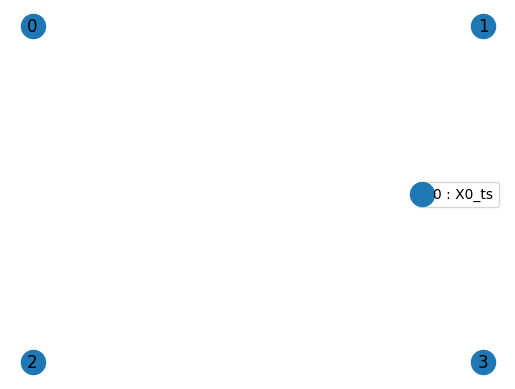

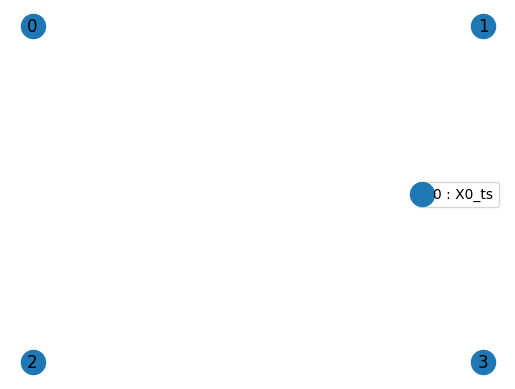

In [9]:
# 1. load m_graph 
m_graph_adj = load_m_graph_adjacency_matrix( m_graph_adj_file = m_graph_adj_gt_file )
m_graph     = MissingDataGraph_ts(   m_graph_adj  = m_graph_adj ) 

# visualize
m_graph.plot() 

In [10]:
# 2. load weights
weights_df = load_logistic_regression_ps_model_weights( ps_model_weights_file = ps_model_weights_gt_file) 

# 3. initialize params
ps_model_params = {}
ps_model_params['base_model_params'] = {  'base_model_type': 'stationary_constant',
                                          'gt_weights': weights_df}

# 4. init ps model
ps_model_name = 'ps_model_gt'
ps_model = PropensityScoreModel_ts( name            = ps_model_name, 
                                    m_graph         = m_graph, 
                                    feature_name    = dataset.feature_name,
                                    target_superfeature_names    = dataset.afa_problem.target_superfeature_names,
                                    model_params = ps_model_params ) 

Change base_model to stationary_constant
Change base_model to stationary_constant
Set weight for constant stationary model ...
Set weight for constant stationary model ...


In [11]:
afa_agent = AFAMechanismAgent_ts(  name      = miss_scenario + '_agent',
                                       ps_model  = ps_model 
                                 )

## Create new dataset using the defined agent

Run the agent as an afa agent over the dataset to create an afa_dataset. Then create a new regular dataset out of it

In [12]:
from afa.afa_datasets.afa_dataset_ts import AFADataset_ts

In [13]:
afa_results = afa_agent.predict(dataset, 
                                ids = None, 
                                fold = None, 
                                split = None,  
                                n_samples = 1) 

# create an afa_dataset out of the generated afa_results
afa_dataset = AFADataset_ts(  dataset = dataset, model = afa_agent, results = afa_results) 

# check retrieving data 
data = afa_dataset.get_data( fold = None, split = None, n_samples = 1) 

Convert superR to R: 100%|██████████| 2/2 [00:00<00:00, 2585.88it/s]


In [14]:
afa_results['target_superR_hat'].shape

(2000, 50, 2)

In [16]:
dataset_new =  afa_dataset.create_new_dataset()

inserting missingness: 100%|██████████| 2000/2000 [02:38<00:00, 12.63it/s]


Success: New and old implementation yield the same result inserting missingness.


In [22]:
type(afa_dataset.dataset)
type(dataset_new)

afa.data_modelling.datasets.dataset_ts.Dataset_ts

In [29]:
np.isnan(dataset_new.temporal_feature).sum(axis=(0,1)) / (dataset_new.temporal_feature.shape[0] * dataset_new.temporal_feature.shape[1])

array([0.     , 0.10066, 0.04926, 0.04926])

In [17]:
dataset_new.temporal_feature

array([[[-0.50420472,  0.71332008,  0.54365684,  0.00690327],
        [-1.07868071,  0.54712735,  0.83903131, -0.17625334],
        [ 0.44676369,         nan,  0.55023545, -0.83245411],
        ...,
        [-0.78649253,  0.73817058, -0.58055368,  1.12505364],
        [-0.17041173,  0.51536838,  0.93142944,  0.69237734],
        [ 0.33540501,  0.62598992,  0.83835013,  1.04985834]],

       [[-0.52453104, -2.13237263,  0.09135608, -0.7246461 ],
        [ 0.17847336,         nan,  0.47534844,  0.35840241],
        [ 0.61924027,         nan, -1.23370907, -0.46072966],
        ...,
        [ 0.19273329,  0.06642369, -1.3086933 , -1.54356751],
        [ 0.01148566, -2.55265379,         nan,         nan],
        [ 1.35719251, -0.57439182,  0.12035853,  0.64955872]],

       [[-0.37622294, -0.20606407, -1.08246362,  0.8697178 ],
        [-1.63452015,  0.05317246, -0.25086504,  1.16919186],
        [ 2.37119174, -1.37333427, -0.50485462,  1.51617329],
        ...,
        [ 1.09904326,  1.10

## Visualize newly created missingness 

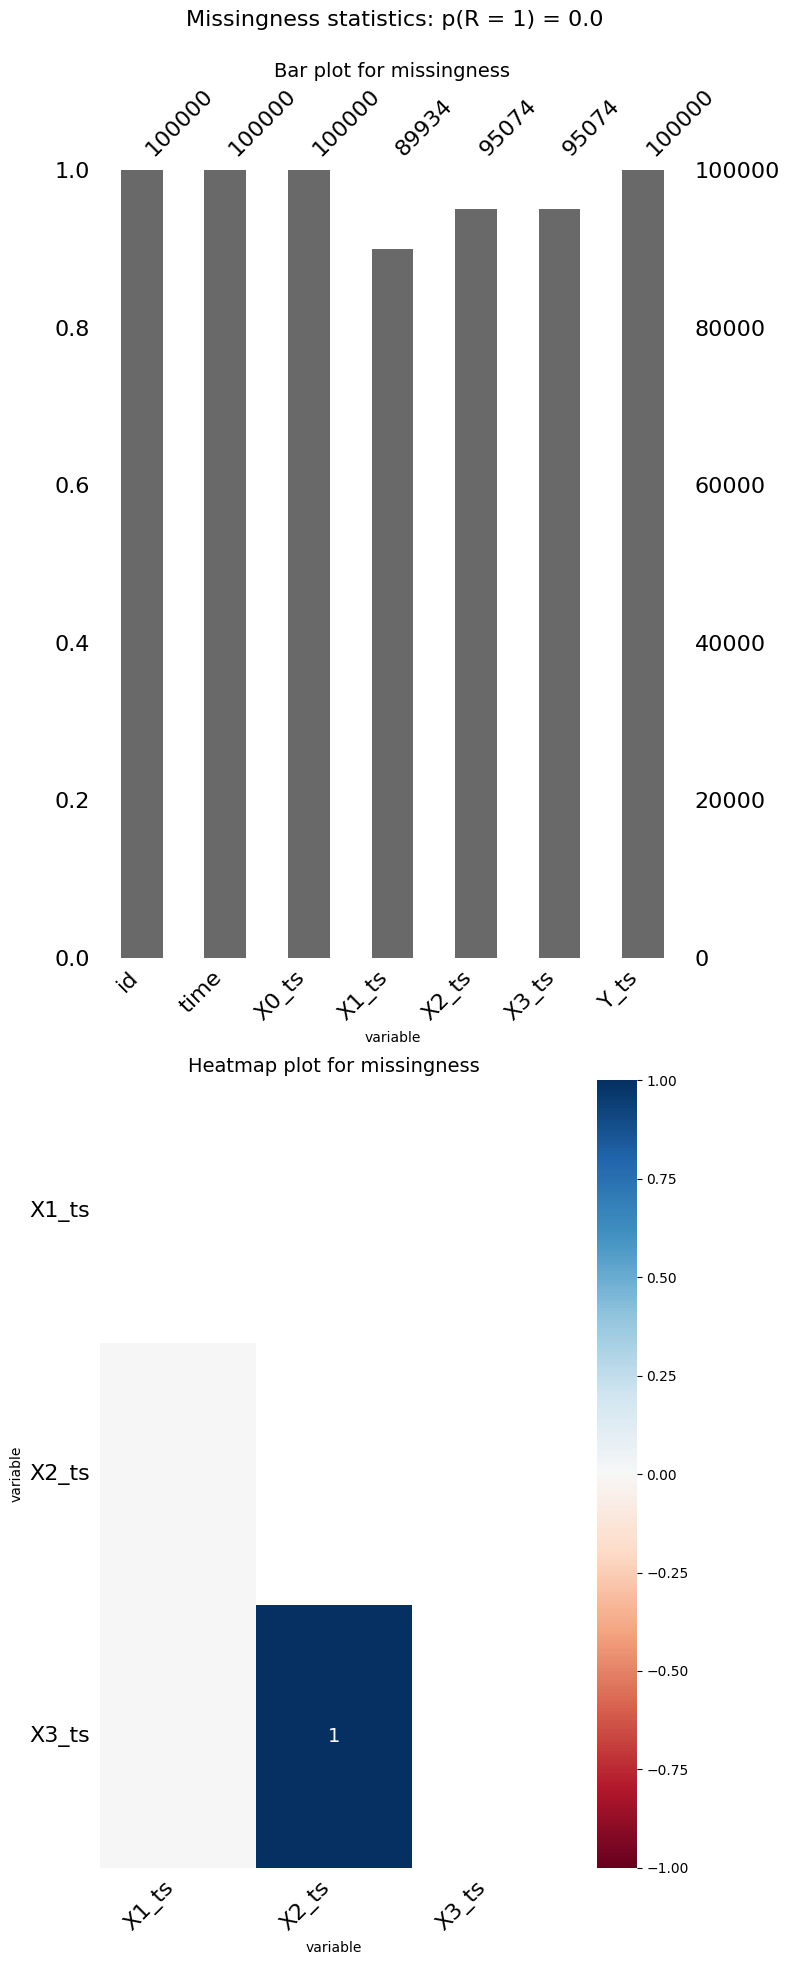

In [35]:
fig = dataset_new.plot_missingness_stats()

## Add the ground truth propensity score to the dataset

For comparison reasons we might be interested in the ground truth propensity score and add it back to dataset_new 

In [31]:
from afa.data_modelling.missingness.missingness_model import MissingnessModel

In [32]:
# compute ps values
ps_values, ps_values_1 = ps_model.predict(dataset_new)

In [33]:
# init miss_model in dataset
miss_model = MissingnessModel(m_graph)
dataset_new.miss_model = miss_model 

In [34]:
# add to dataset
dataset_new.miss_model.add_ps_values( ps_model_name , 
                                      ps_values = ps_values, 
                                      ps_values_1 = ps_values_1 )

## Save the new dataset

In [36]:
dataset_new.save( data_dir = paths_miss['data_dir'], 
                  dataset_name = dataset_name + '_' + miss_scenario, 
                  save_folds = True) 

In [37]:
dataset_new.miss_model.save(paths_miss['data_dir'])

## Reporting: summarize the whole dataset (with missingness) 
Store information in reports folder in latex / markdown format.

FileNotFoundError: [Errno 2] No such file or directory: 'pandoc'

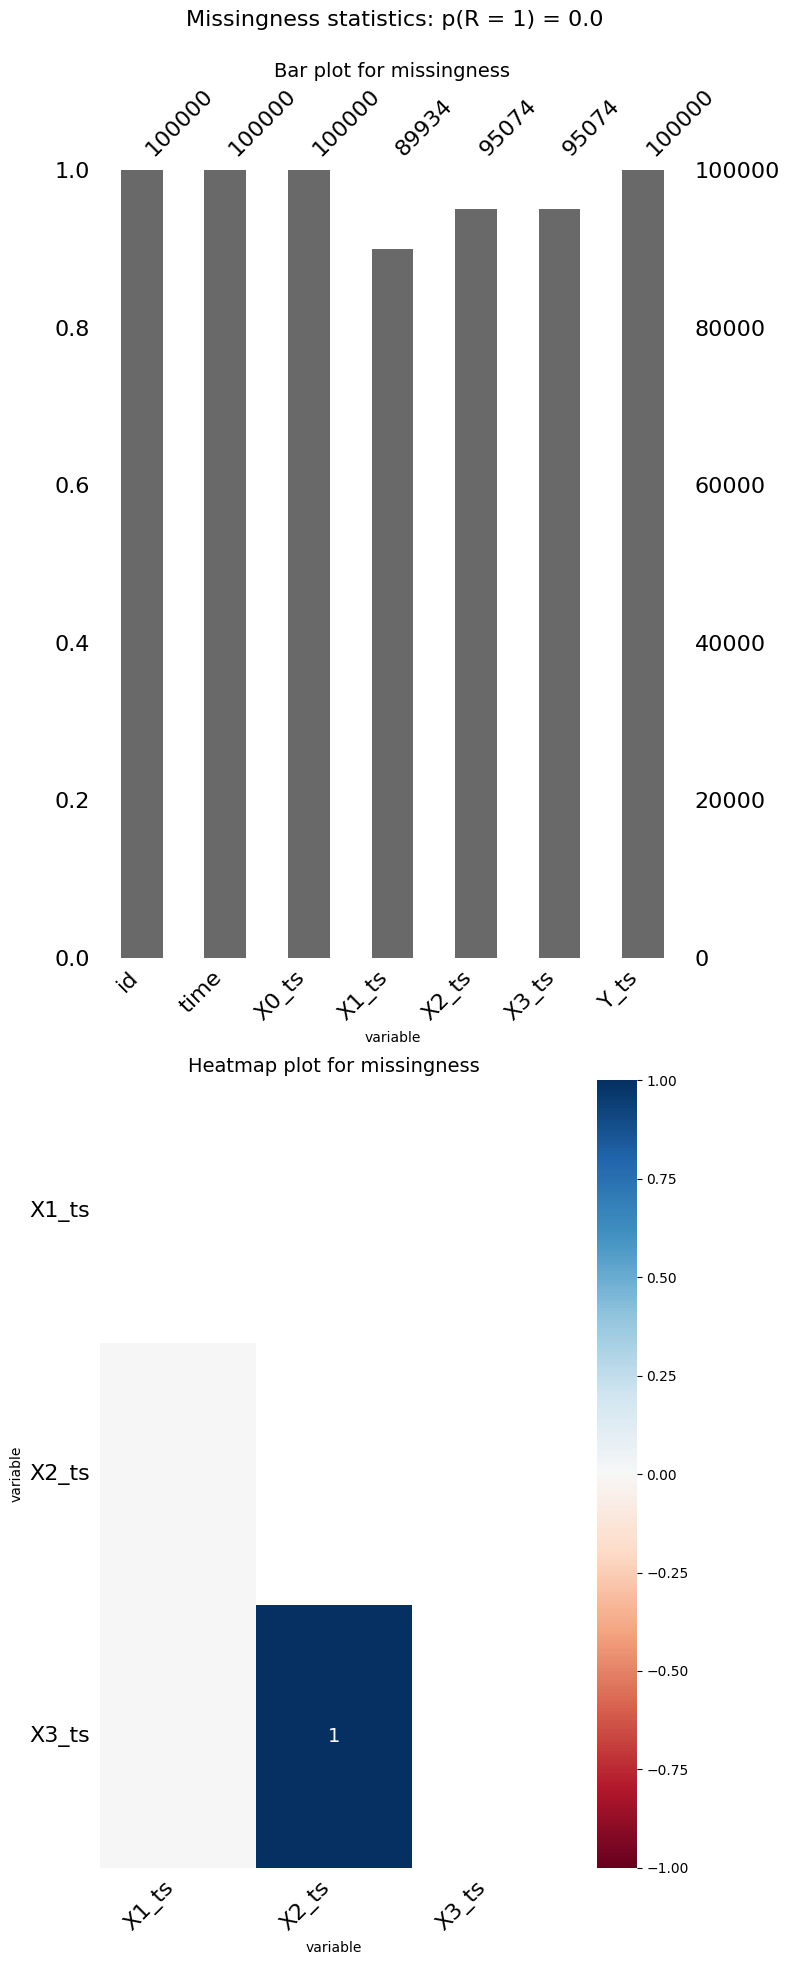

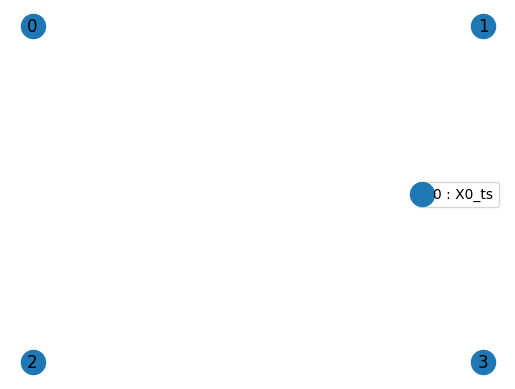

In [38]:
# reporting
explanation_file = paths_miss['data_dir'] + 'dataset_report'
dataset_new.explain(file=  explanation_file + '.md', format = 'markdown')
# dataset_new.explain(file=  explanation_file + '.tex', format = 'latex')